In [44]:
#GROUP 1 - BMEN 623 
#Kennedy Connors 
#Regan Kane
#Sepehr Akhiani

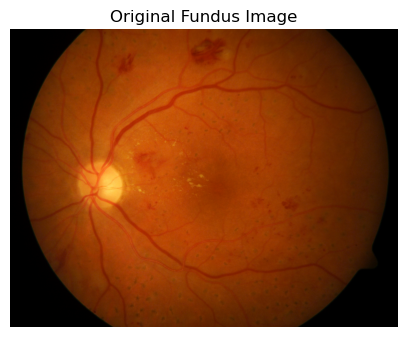

In [1]:
# RETINAL BLOOD VESSEL SEGMENTATION PIPELINE 
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte
from PIL import Image

# Set up folders 
INPUT_FOLDER = 'images/'
PREPROC_FOLDER = 'preprocessed/'
RESULT_FOLDER = 'results/segmented_enhanced/'

# Create folders
os.makedirs(PREPROC_FOLDER + 'gray', exist_ok=True)
os.makedirs(PREPROC_FOLDER + 'clahe', exist_ok=True)
os.makedirs(PREPROC_FOLDER + 'od_removed', exist_ok=True)
os.makedirs(PREPROC_FOLDER + 'blurred', exist_ok=True)
os.makedirs(RESULT_FOLDER, exist_ok=True)

# Select a sample image for visualization 
sample_image = 'diaretdb1_image008.png'
sample_base = os.path.splitext(sample_image)[0]

# Load and visualize original 
original_img = Image.open(os.path.join(INPUT_FOLDER, sample_image))
plt.figure(figsize=(5, 5))
plt.imshow(original_img)
plt.axis('off')
plt.title("Original Fundus Image")
plt.show()


In [2]:
# PREPROCESSING PIPELINE (AIM 1: Develop a preprocessing pipeline for retinal fundus images + OD removal)
for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(('.png', '.jpg')):
        img_path = os.path.join(INPUT_FOLDER, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip files that cannot be read

        name, _ = os.path.splitext(filename)

        # Step 1: Convert to Grayscale
        # Simplifies image by reducing to single intensity channel
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(f'{PREPROC_FOLDER}gray/{name}_gray.png', gray)

        # Step 2: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        # Enhances local contrast in retinal images to improve vessel visibility
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(gray)
        cv2.imwrite(f'{PREPROC_FOLDER}clahe/{name}_clahe.png', clahe_img)

        # Step 3: Optic Disc Localization via Thresholding and Morphological Operations
        # Threshold bright regions (e.g., optic disc) to create binary mask
        _, thresh = cv2.threshold(clahe_img, 220, 255, cv2.THRESH_BINARY)

        # Apply morphological closing and opening to smooth the OD mask
        kernel = np.ones((15, 15), np.uint8)
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

        # Find contours and keep the largest one (assumed to be the optic disc)
        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(clahe_img)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask, [largest], -1, 255, -1)  # Fill the OD mask

        # Step 4: Remove Optic Disc from Image
        # Mask the OD region by setting pixels in the OD area to zero
        od_removed = clahe_img.copy()
        od_removed[mask == 255] = 0
        cv2.imwrite(f'{PREPROC_FOLDER}od_removed/{name}_od_removed.png', od_removed)

        # Step 5: Apply Gaussian Blur to reduce high-frequency noise
        # Smoothing improves robustness of later edge detection and thresholding
        blurred = cv2.GaussianBlur(od_removed, (5, 5), 0)
        cv2.imwrite(f'{PREPROC_FOLDER}blurred/{name}_blurred.png', blurred)

        print(f"Preprocessed: {filename}")


Preprocessed: diaretdb1_image074.png
Preprocessed: diaretdb1_image060.png
Preprocessed: diaretdb1_image048.png
Preprocessed: diaretdb1_image049.png
Preprocessed: diaretdb1_image061.png
Preprocessed: diaretdb1_image075.png
Preprocessed: diaretdb1_image088.png
Preprocessed: diaretdb1_image063.png
Preprocessed: diaretdb1_image077.png
Preprocessed: diaretdb1_image076.png
Preprocessed: diaretdb1_image062.png
Preprocessed: diaretdb1_image089.png
Preprocessed: diaretdb1_image066.png
Preprocessed: diaretdb1_image072.png
Preprocessed: diaretdb1_image073.png
Preprocessed: diaretdb1_image067.png
Preprocessed: diaretdb1_image059.png
Preprocessed: diaretdb1_image071.png
Preprocessed: diaretdb1_image065.png
Preprocessed: diaretdb1_image064.png
Preprocessed: diaretdb1_image070.png
Preprocessed: diaretdb1_image058.png
Preprocessed: diaretdb1_image017.png
Preprocessed: diaretdb1_image003.png
Preprocessed: diaretdb1_image002.png
Preprocessed: diaretdb1_image016.png
Preprocessed: diaretdb1_image014.png
P

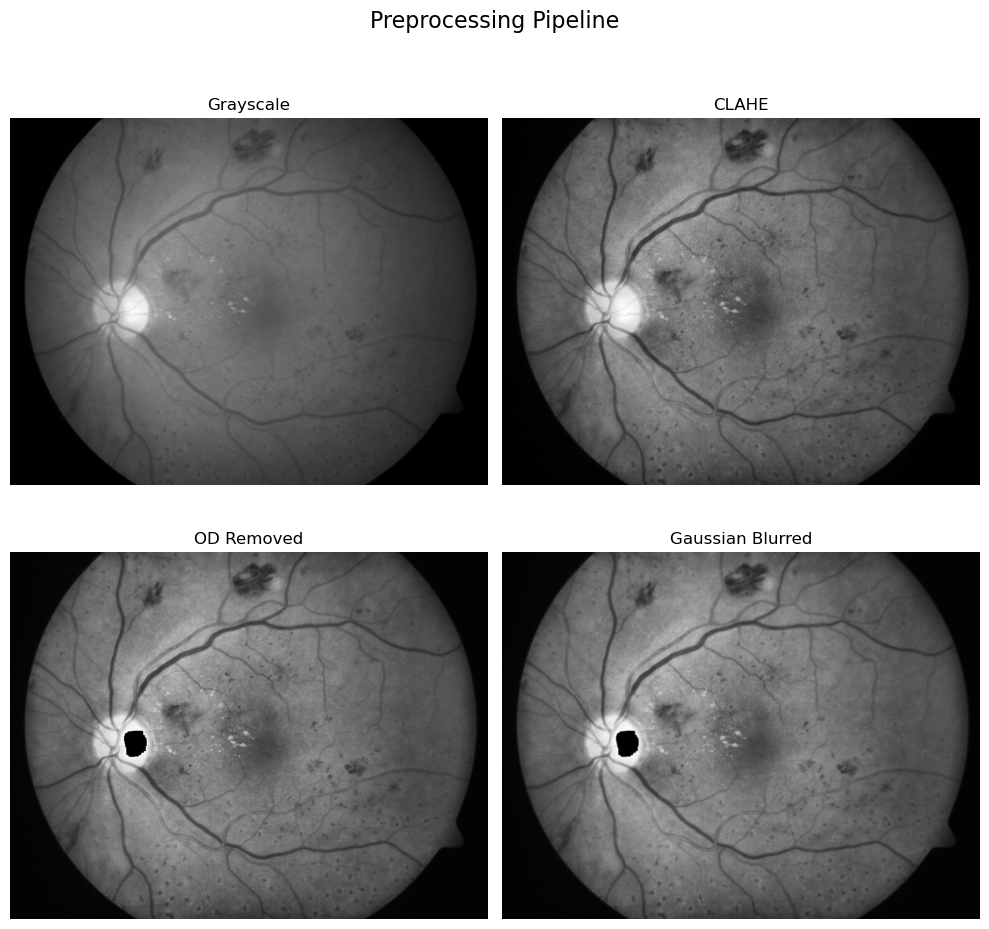

In [3]:
# DISPLAY PREPROCESSING STEPS FOR SAMPLE IMAGE 
if os.path.exists(f'{PREPROC_FOLDER}gray/{sample_base}_gray.png'):
    gray = cv2.imread(f'{PREPROC_FOLDER}gray/{sample_base}_gray.png', cv2.IMREAD_GRAYSCALE)
    clahe_img = cv2.imread(f'{PREPROC_FOLDER}clahe/{sample_base}_clahe.png', cv2.IMREAD_GRAYSCALE)
    od_removed = cv2.imread(f'{PREPROC_FOLDER}od_removed/{sample_base}_od_removed.png', cv2.IMREAD_GRAYSCALE)
    blurred = cv2.imread(f'{PREPROC_FOLDER}blurred/{sample_base}_blurred.png', cv2.IMREAD_GRAYSCALE)

    steps = [gray, clahe_img, od_removed, blurred]
    titles = ['Grayscale', 'CLAHE', 'OD Removed', 'Gaussian Blurred']
    plt.figure(figsize=(10, 10)) 
    
    for i, (img_step, title) in enumerate(zip(steps, titles)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(img_step, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.suptitle("Preprocessing Pipeline", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) 
    plt.show()

In [4]:
# SEGMENTATION PIPELINE (AIM 2: Implement and refine blood vessel segmentation techniques)
for filename in os.listdir(PREPROC_FOLDER + 'blurred'):
    if filename.endswith('.png'):
        path = os.path.join(PREPROC_FOLDER, 'blurred', filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Skip if image could not be loaded

        # Step 1: Adaptive Thresholding
        # Highlights vessel-like structures by thresholding local regions
        adaptive = cv2.adaptiveThreshold(
            img,                     # Input grayscale image
            255,                     # Max value after thresholding
            cv2.ADAPTIVE_THRESH_MEAN_C,  # Thresholding method
            cv2.THRESH_BINARY_INV,       # Invert: vessels become white
            15,                      # Block size (odd number, controls local region)
            10                       # Constant subtracted from mean (tunes sensitivity)
        )

        # Step 2: Canny Edge Detection
        # Detects sharp intensity gradients that often correspond to vessel edges
        edges = cv2.Canny(
            img,
            threshold1=30,  # Lower bound
            threshold2=90   # Upper bound
        )

        # Step 3: Combine Threshold and Edge Maps
        # Logical OR: combine vessels from adaptive and edge detection
        combined = cv2.bitwise_or(adaptive, edges)

        # Step 4: Morphological Operations
        # Clean up noise and connect fragmented vessels
        kernel = np.ones((3, 3), np.uint8)
        morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)  # Close small gaps
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)      # Remove small noise

        # Step 5: Skeletonization
        # Thins vessels to single-pixel width to preserve shape while simplifying
        skeleton = skeletonize(img_as_bool(morph))      # Convert to boolean and skeletonize
        final = img_as_ubyte(skeleton)                  # Convert back to uint8 for saving

        # Step 6: Save Output
        name, _ = os.path.splitext(filename)
        cv2.imwrite(os.path.join(RESULT_FOLDER, f'{name}_segmented.png'), final)
        print(f"Segmented: {filename}")

Segmented: diaretdb1_image063_blurred.png
Segmented: diaretdb1_image013_blurred.png
Segmented: diaretdb1_image021_blurred.png
Segmented: diaretdb1_image051_blurred.png
Segmented: diaretdb1_image082_blurred.png
Segmented: diaretdb1_image034_blurred.png
Segmented: diaretdb1_image044_blurred.png
Segmented: diaretdb1_image058_blurred.png
Segmented: diaretdb1_image028_blurred.png
Segmented: diaretdb1_image076_blurred.png
Segmented: diaretdb1_image006_blurred.png
Segmented: diaretdb1_image041_blurred.png
Segmented: diaretdb1_image031_blurred.png
Segmented: diaretdb1_image003_blurred.png
Segmented: diaretdb1_image073_blurred.png
Segmented: diaretdb1_image038_blurred.png
Segmented: diaretdb1_image048_blurred.png
Segmented: diaretdb1_image016_blurred.png
Segmented: diaretdb1_image066_blurred.png
Segmented: diaretdb1_image087_blurred.png
Segmented: diaretdb1_image054_blurred.png
Segmented: diaretdb1_image024_blurred.png
Segmented: diaretdb1_image057_blurred.png
Segmented: diaretdb1_image027_blur

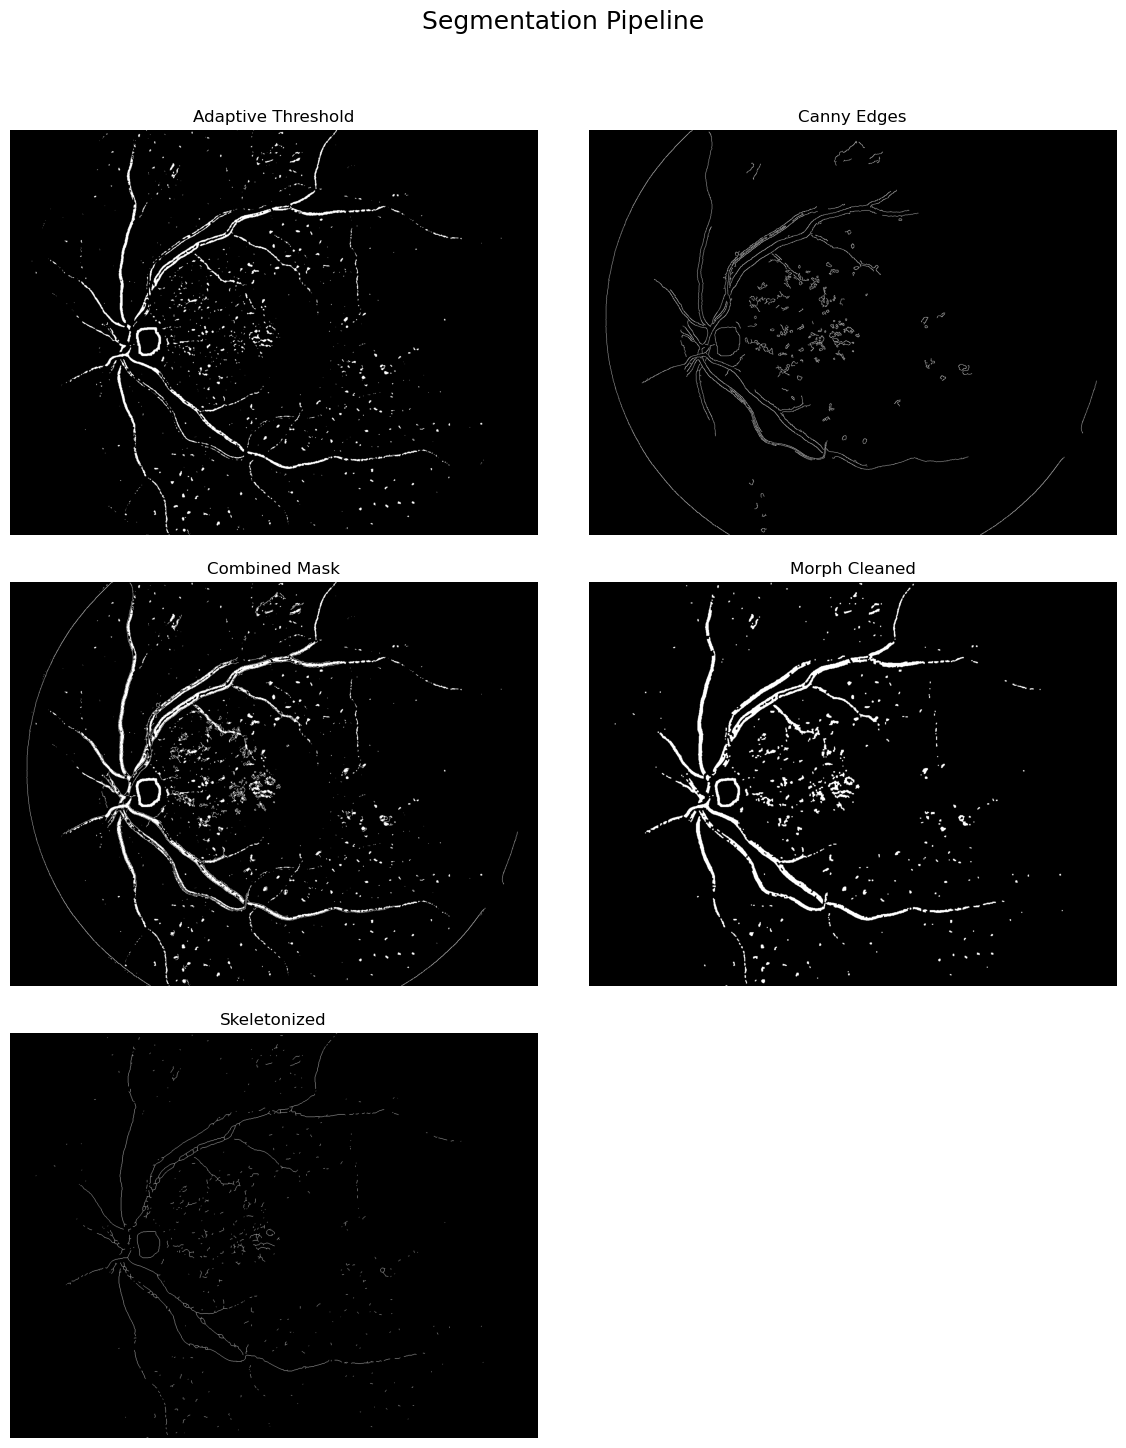

In [5]:
# DISPLAY SEGMENTATION STEPS FOR SAMPLE IMAGE 
sample_blur_path = f'{PREPROC_FOLDER}blurred/{sample_base}_blurred.png'
if os.path.exists(sample_blur_path):
    img = cv2.imread(sample_blur_path, cv2.IMREAD_GRAYSCALE)
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 15, 10)
    edges = cv2.Canny(img, 30, 90)
    combined = cv2.bitwise_or(adaptive, edges)
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
    skeleton = skeletonize(img_as_bool(morph))
    final = img_as_ubyte(skeleton)

    steps = [adaptive, edges, combined, morph, final]
    titles = ['Adaptive Threshold', 'Canny Edges', 'Combined Mask', 'Morph Cleaned', 'Skeletonized']
    plt.figure(figsize=(12, 15)) 
    for i, (img_step, title) in enumerate(zip(steps, titles)):
        plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns
        plt.imshow(img_step, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.suptitle("Segmentation Pipeline", fontsize=18)
    plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.98])  
    plt.show()

In [ ]:
##############################################
#GREEN CHANNEL EXTRACTION 
##############################################

#Purpose: compare preprocessing of grayscale versus green channel 
#Why? : Green channel and grayscale are both used in preprocessing for segmentation. Green channel is preferred because it allows better visualization of the vessels. 
#We wanted to assess if there is a difference in the segementation results as many studies use either Grayscale or Green Channel. 

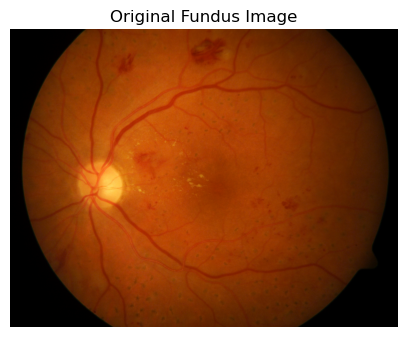

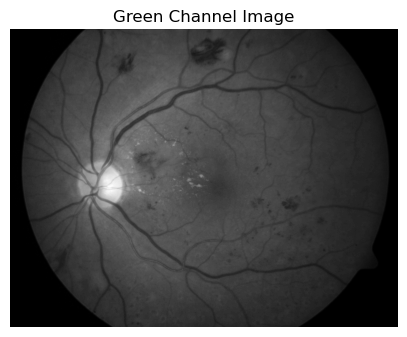

In [46]:
#Green Channel Extraction 
#1. Reformat for Green Channel 
# RETINAL BLOOD VESSEL SEGMENTATION PIPELINE 
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte
from PIL import Image

#Create folder for green-channel images
os.makedirs(PREPROC_FOLDER + 'green_channel', exist_ok=True)

# Select a sample image for visualization 
sample_image = 'diaretdb1_image008.png'
sample_base = os.path.splitext(sample_image)[0]

# Load and visualize original 
original_img = Image.open(os.path.join(INPUT_FOLDER, sample_image))
plt.figure(figsize=(5, 5))
plt.imshow(original_img)
plt.axis('off')
plt.title("Original Fundus Image")
plt.show()

# Convert to numpy array and extract green channel
green_channel = np.array(original_img)[:, :, 1]  # Extract green channel

# Save green channel image
cv2.imwrite(os.path.join(PREPROC_FOLDER, 'green_channel', sample_base + '_green.png'), green_channel)

# Display green channel image
plt.figure(figsize=(5, 5))
plt.imshow(green_channel, cmap='gray')
plt.axis('off')
plt.title("Green Channel Image")
plt.show()


Preprocessed (Green Channel): diaretdb1_image074.png
Preprocessed (Green Channel): diaretdb1_image060.png
Preprocessed (Green Channel): diaretdb1_image048.png
Preprocessed (Green Channel): diaretdb1_image049.png
Preprocessed (Green Channel): diaretdb1_image061.png
Preprocessed (Green Channel): diaretdb1_image075.png
Preprocessed (Green Channel): diaretdb1_image088.png
Preprocessed (Green Channel): diaretdb1_image063.png
Preprocessed (Green Channel): diaretdb1_image077.png
Preprocessed (Green Channel): diaretdb1_image076.png
Preprocessed (Green Channel): diaretdb1_image062.png
Preprocessed (Green Channel): diaretdb1_image089.png
Preprocessed (Green Channel): diaretdb1_image066.png
Preprocessed (Green Channel): diaretdb1_image072.png
Preprocessed (Green Channel): diaretdb1_image073.png
Preprocessed (Green Channel): diaretdb1_image067.png
Preprocessed (Green Channel): diaretdb1_image059.png
Preprocessed (Green Channel): diaretdb1_image071.png
Preprocessed (Green Channel): diaretdb1_image0

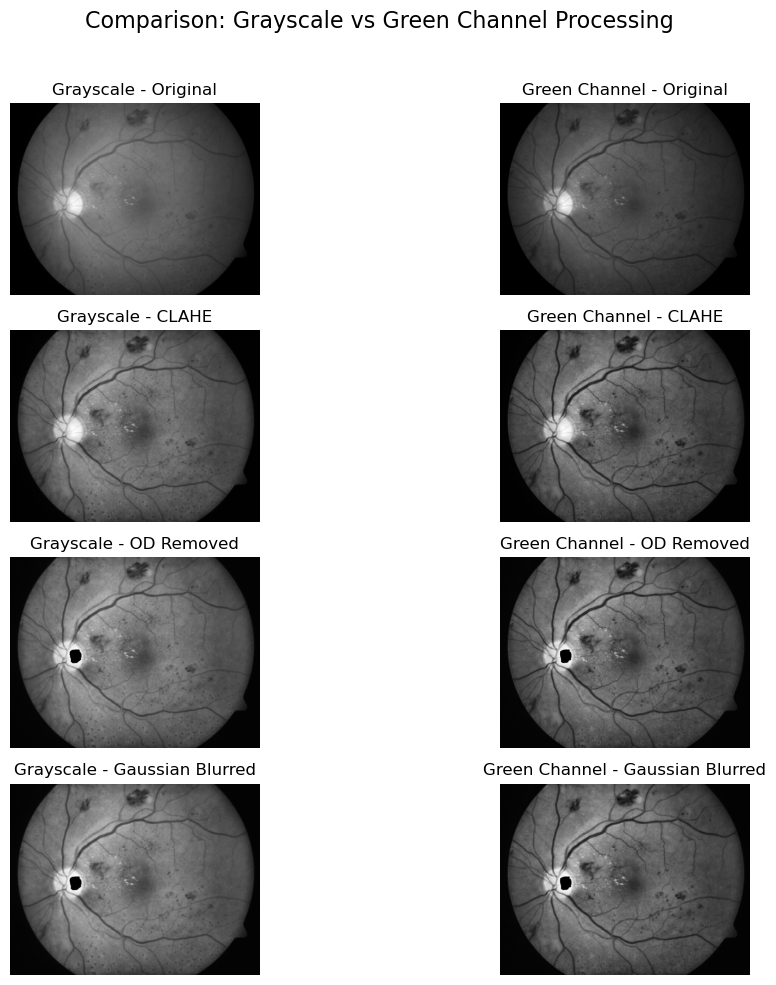

In [48]:
# RETINAL BLOOD VESSEL PREPROCESSING PIPELINE (Using Green Channel)
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte
from PIL import Image

# Set up folders 
INPUT_FOLDER = 'images/'
PREPROC_FOLDER = 'preprocessed/'
RESULT_FOLDER = 'results/segmented_enhanced/'

# Create folders
os.makedirs(PREPROC_FOLDER + 'green_channel', exist_ok=True)
os.makedirs(PREPROC_FOLDER + 'green_channel_clahe', exist_ok=True)  # Renamed CLAHE for green channel
os.makedirs(PREPROC_FOLDER + 'green_channel_od_removed', exist_ok=True)  # Renamed OD removed for green channel
os.makedirs(PREPROC_FOLDER + 'green_channel_blurred', exist_ok=True)  # Renamed blurred for green channel
os.makedirs(RESULT_FOLDER, exist_ok=True)

# PROCESS EACH IMAGE IN THE INPUT FOLDER
for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(('.png', '.jpg')):
        img_path = os.path.join(INPUT_FOLDER, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip files that cannot be read

        name, _ = os.path.splitext(filename)

        # Step 1: Extract Green Channel (instead of Grayscale)
        green_channel = img[:, :, 1]  # Extract green channel
        cv2.imwrite(f'{PREPROC_FOLDER}green_channel/{name}_green.png', green_channel)

        # Step 2: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(green_channel)
        cv2.imwrite(f'{PREPROC_FOLDER}green_channel_clahe/{name}_green_clahe.png', clahe_img)

        # Step 3: Optic Disc Localization via Thresholding and Morphological Operations
        _, thresh = cv2.threshold(clahe_img, 220, 255, cv2.THRESH_BINARY)

        kernel = np.ones((15, 15), np.uint8)
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(clahe_img)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask, [largest], -1, 255, -1)  

        # Step 4: Remove Optic Disc from Image
        od_removed = clahe_img.copy()
        od_removed[mask == 255] = 0
        cv2.imwrite(f'{PREPROC_FOLDER}green_channel_od_removed/{name}_green_od_removed.png', od_removed)

        # Step 5: Apply Gaussian Blur
        blurred = cv2.GaussianBlur(od_removed, (5, 5), 0)
        cv2.imwrite(f'{PREPROC_FOLDER}green_channel_blurred/{name}_green_blurred.png', blurred)

        print(f"Preprocessed (Green Channel): {filename}")

# COMPARISON BETWEEN GRAYSCALE AND GREEN CHANNEL PROCESSING
if os.path.exists(f'{PREPROC_FOLDER}gray/{sample_base}_gray.png') and os.path.exists(f'{PREPROC_FOLDER}green_channel/{sample_base}_green.png'):
    # Load grayscale-based preprocessing
    gray = cv2.imread(f'{PREPROC_FOLDER}gray/{sample_base}_gray.png', cv2.IMREAD_GRAYSCALE)
    clahe_gray = cv2.imread(f'{PREPROC_FOLDER}clahe/{sample_base}_clahe.png', cv2.IMREAD_GRAYSCALE)
    od_removed_gray = cv2.imread(f'{PREPROC_FOLDER}od_removed/{sample_base}_od_removed.png', cv2.IMREAD_GRAYSCALE)
    blurred_gray = cv2.imread(f'{PREPROC_FOLDER}blurred/{sample_base}_blurred.png', cv2.IMREAD_GRAYSCALE)

    # Load green-channel-based preprocessing
    green = cv2.imread(f'{PREPROC_FOLDER}green_channel/{sample_base}_green.png', cv2.IMREAD_GRAYSCALE)
    clahe_green = cv2.imread(f'{PREPROC_FOLDER}green_channel_clahe/{sample_base}_green_clahe.png', cv2.IMREAD_GRAYSCALE)
    od_removed_green = cv2.imread(f'{PREPROC_FOLDER}green_channel_od_removed/{sample_base}_green_od_removed.png', cv2.IMREAD_GRAYSCALE)
    blurred_green = cv2.imread(f'{PREPROC_FOLDER}green_channel_blurred/{sample_base}_green_blurred.png', cv2.IMREAD_GRAYSCALE)

    steps_gray = [gray, clahe_gray, od_removed_gray, blurred_gray]
    steps_green = [green, clahe_green, od_removed_green, blurred_green]
    titles = ['Original', 'CLAHE', 'OD Removed', 'Gaussian Blurred']

    # Display side-by-side comparison
    plt.figure(figsize=(12, 10)) 
    for i, (gray_step, green_step, title) in enumerate(zip(steps_gray, steps_green, titles)):
        plt.subplot(4, 2, 2 * i + 1)
        plt.imshow(gray_step, cmap='gray')
        plt.title(f"Grayscale - {title}")
        plt.axis('off')

        plt.subplot(4, 2, 2 * i + 2)
        plt.imshow(green_step, cmap='gray')
        plt.title(f"Green Channel - {title}")
        plt.axis('off')

    plt.suptitle("Comparison: Grayscale vs Green Channel Processing", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.show()

#Vessels appear slightly darker in Green channel extraction versus Grayscale. Can see smaller vessels a bit clearer. 


In [9]:
# SEGMENTATION PIPELINE for Green Channel (AIM 2: Implement and refine blood vessel segmentation techniques)
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte

# Set up folders
PREPROC_FOLDER = 'preprocessed/'
RESULT_FOLDER = 'results/segmented_enhanced/'

# Ensure result folders exist for both grayscale and green-channel segmentations
os.makedirs(RESULT_FOLDER + 'gray', exist_ok=True)
os.makedirs(RESULT_FOLDER + 'green', exist_ok=True)

# Process both grayscale and green-channel blurred images
for color_type in ['blurred', 'green_channel_blurred']:
    input_path = os.path.join(PREPROC_FOLDER, color_type)

    for filename in os.listdir(input_path):
        if filename.endswith('.png'):
            img_path = os.path.join(input_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # Skip if image could not be loaded

            # Step 1: Adaptive Thresholding
            adaptive = cv2.adaptiveThreshold(
                img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
            )

            # Step 2: Canny Edge Detection
            edges = cv2.Canny(img, threshold1=30, threshold2=90)

            # Step 3: Combine Threshold and Edge Maps
            combined = cv2.bitwise_or(adaptive, edges)

            # Step 4: Morphological Operations
            kernel = np.ones((3, 3), np.uint8)
            morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
            morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

            # Step 5: Skeletonization
            skeleton = skeletonize(img_as_bool(morph))
            final = img_as_ubyte(skeleton)

            # Step 6: Save Output
            name, _ = os.path.splitext(filename)
            output_subfolder = 'gray' if color_type == 'blurred' else 'green'
            cv2.imwrite(os.path.join(RESULT_FOLDER, output_subfolder, f'{name}_segmented.png'), final)

            print(f"Segmented ({output_subfolder}): {filename}")

# Comparison of Grayscale vs Green Channel Segmentation
sample_base = 'example'  # Change to an actual filename without extension for visualization
gray_result_path = os.path.join(RESULT_FOLDER, 'gray', f'{sample_base}_segmented.png')
green_result_path = os.path.join(RESULT_FOLDER, 'green', f'{sample_base}_segmented.png')

if os.path.exists(gray_result_path) and os.path.exists(green_result_path):
    gray_segmented = cv2.imread(gray_result_path, cv2.IMREAD_GRAYSCALE)
    green_segmented = cv2.imread(green_result_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gray_segmented, cmap='gray')
    plt.title('Grayscale Segmentation')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(green_segmented, cmap='gray')
    plt.title('Green Channel Segmentation')
    plt.axis('off')

    plt.suptitle('Comparison: Grayscale vs Green Channel Segmentation', fontsize=14)
    plt.tight_layout()
    plt.show()


Segmented (gray): diaretdb1_image063_blurred.png
Segmented (gray): diaretdb1_image013_blurred.png
Segmented (gray): diaretdb1_image021_blurred.png
Segmented (gray): diaretdb1_image051_blurred.png
Segmented (gray): diaretdb1_image082_blurred.png
Segmented (gray): diaretdb1_image034_blurred.png
Segmented (gray): diaretdb1_image044_blurred.png
Segmented (gray): diaretdb1_image058_blurred.png
Segmented (gray): diaretdb1_image028_blurred.png
Segmented (gray): diaretdb1_image076_blurred.png
Segmented (gray): diaretdb1_image006_blurred.png
Segmented (gray): diaretdb1_image041_blurred.png
Segmented (gray): diaretdb1_image031_blurred.png
Segmented (gray): diaretdb1_image003_blurred.png
Segmented (gray): diaretdb1_image073_blurred.png
Segmented (gray): diaretdb1_image038_blurred.png
Segmented (gray): diaretdb1_image048_blurred.png
Segmented (gray): diaretdb1_image016_blurred.png
Segmented (gray): diaretdb1_image066_blurred.png
Segmented (gray): diaretdb1_image087_blurred.png
Segmented (gray): di

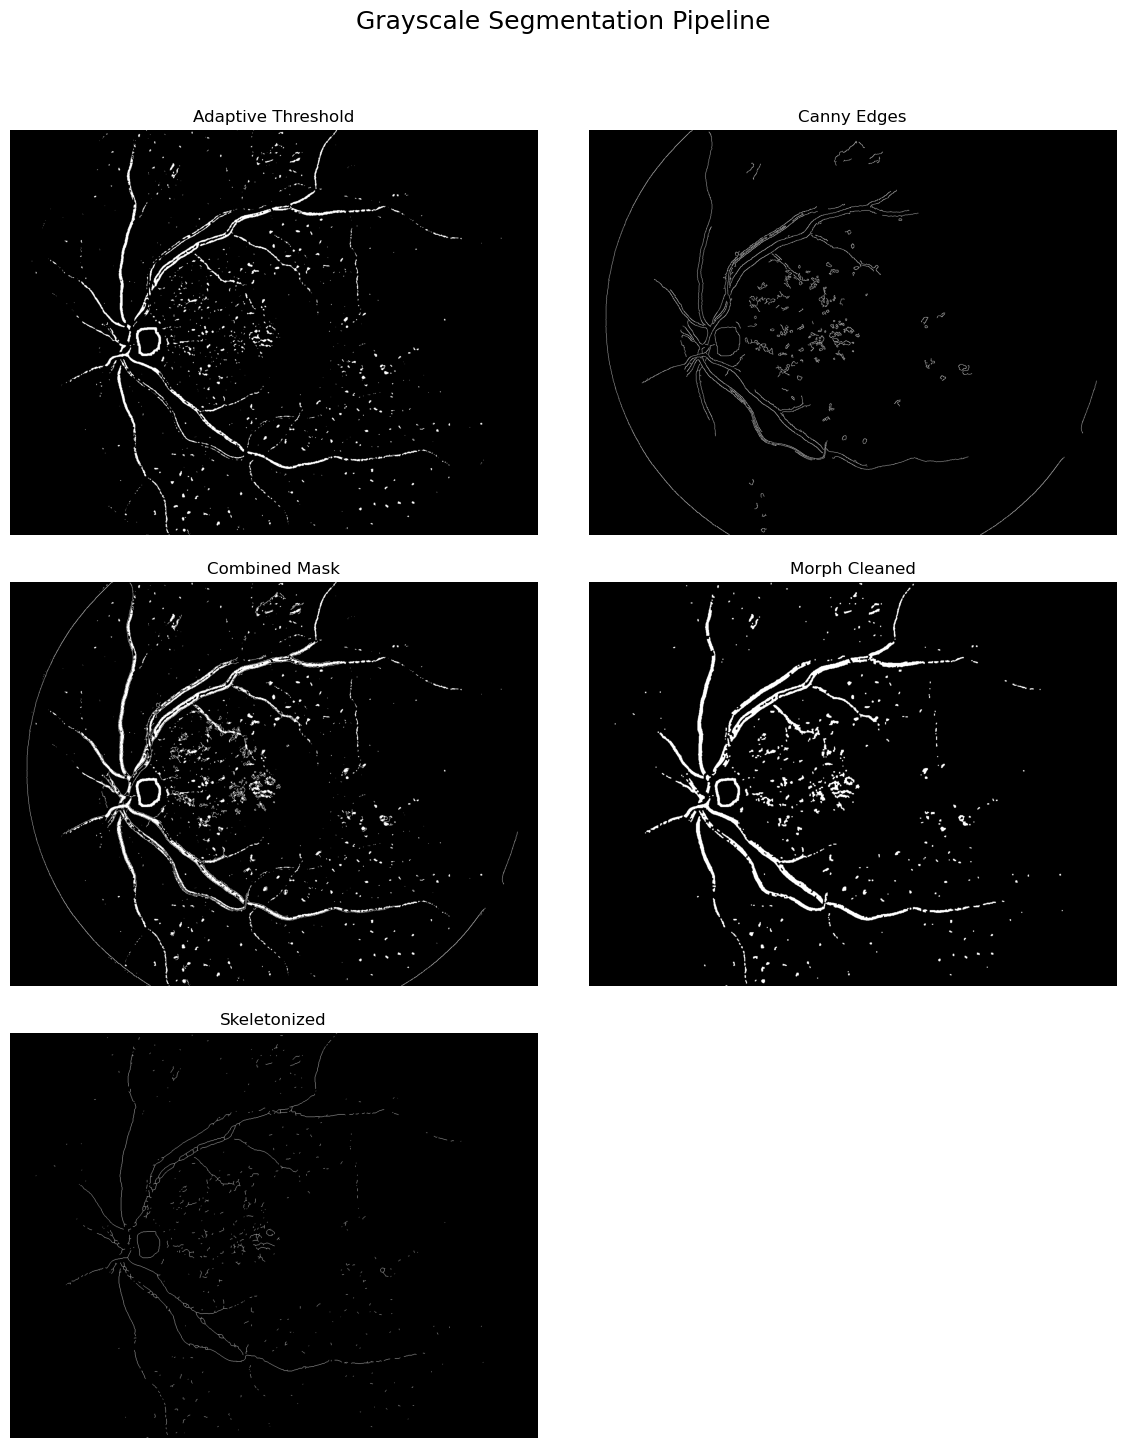

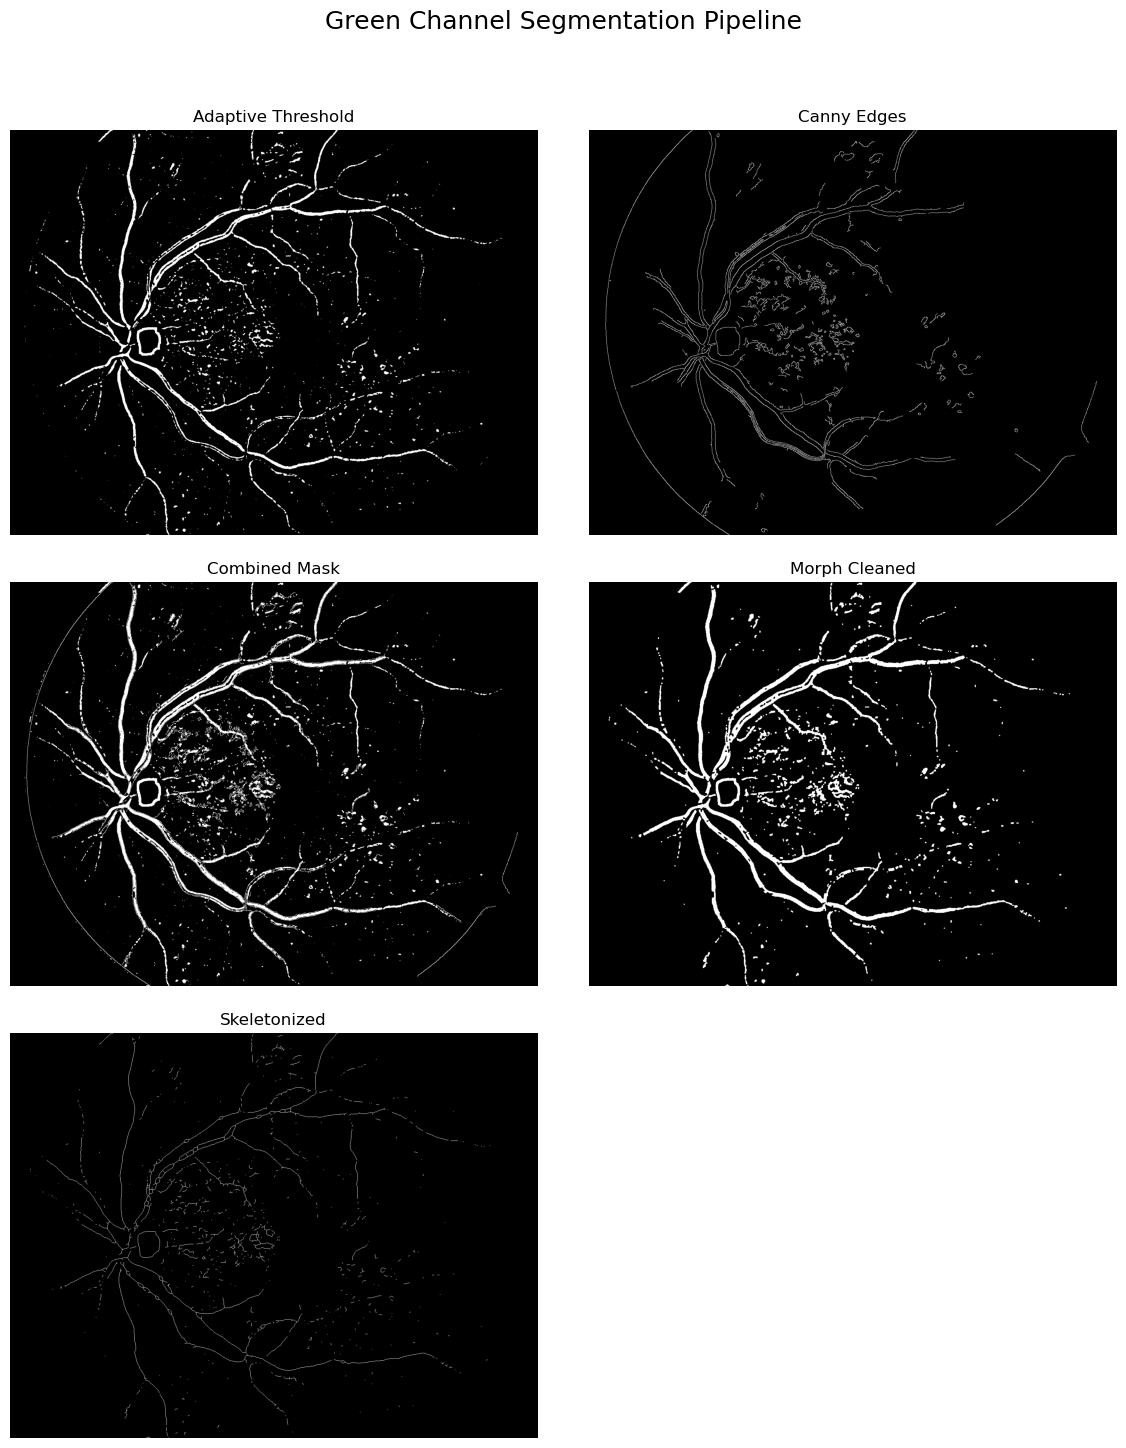

In [50]:
# DISPLAY SEGMENTATION STEPS FOR SAMPLE IMAGE GRAYSCALE 
sample_blur_path = f'{PREPROC_FOLDER}blurred/{sample_base}_blurred.png'
if os.path.exists(sample_blur_path):
    img = cv2.imread(sample_blur_path, cv2.IMREAD_GRAYSCALE)
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 15, 10)
    edges = cv2.Canny(img, 30, 90)
    combined = cv2.bitwise_or(adaptive, edges)
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
    skeleton = skeletonize(img_as_bool(morph))
    final = img_as_ubyte(skeleton)

    steps = [adaptive, edges, combined, morph, final]
    titles = ['Adaptive Threshold', 'Canny Edges', 'Combined Mask', 'Morph Cleaned', 'Skeletonized']
    plt.figure(figsize=(12, 15)) 
    for i, (img_step, title) in enumerate(zip(steps, titles)):
        plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns
        plt.imshow(img_step, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.suptitle("Grayscale Segmentation Pipeline", fontsize=18)
    plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.98])  
    plt.show()


#DISPLAY FOR GREEN CHANNEL
#DISPLAY SEGMENTATION STEPS FOR SAMPLE IMAGE GREEN CHANNEL
sample_blur_path = f'{PREPROC_FOLDER}green_channel_blurred/{sample_base}_green_blurred.png'

if os.path.exists(sample_blur_path):
    img = cv2.imread(sample_blur_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale since it's already green
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 15, 10)
    edges = cv2.Canny(img, 30, 90)
    combined = cv2.bitwise_or(adaptive, edges)

    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

    skeleton = skeletonize(img_as_bool(morph))
    final = img_as_ubyte(skeleton)

    steps = [adaptive, edges, combined, morph, final]
    titles = ['Adaptive Threshold', 'Canny Edges', 'Combined Mask', 'Morph Cleaned', 'Skeletonized']

    plt.figure(figsize=(12, 15))
    for i, (img_step, title) in enumerate(zip(steps, titles)):
        plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns
        plt.imshow(img_step, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.suptitle("Green Channel Segmentation Pipeline", fontsize=18)
    plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.98])
    plt.show()



In [52]:
#RESULTS - Show us that using grayscale or green channel result in very similar segementation pipelines. The green channel segmentation pipelines show us abit more fine detail in the Canny and Skeletonized images. Current research uses either Grayscale or Green channel for preprocessing, which we can see are very similar. Green channel may be preferred because it allows for the finer details which may be more effective in identifying pathologies.